In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

case_pqtl_path = "/LARGE0/gr10478/b37974/Pulmonary_Hypertension/cteph_known_loci/known_pro_assoc/06.pqtl/CTEPH_pqtl_result.pkl"
control_pqtl_path = "/LARGE0/gr10478/b37974/Pulmonary_Hypertension/cteph_known_loci/known_pro_assoc/06.pqtl/NAGA_pqtl_result.pkl"
known_loci_path = "/LARGE0/gr10478/b37974/Pulmonary_Hypertension/cteph_known_loci/datasrc/cteph_reported_loci.xlsx" 

case_pqtl = pd.read_pickle(case_pqtl_path)
control_pqtl = pd.read_pickle(control_pqtl_path)
known_loci = pd.read_excel(known_loci_path)

In [2]:
model = "additive"

In [22]:
from concurrent.futures import ThreadPoolExecutor

def process_key(key):
    case_ids = case_pqtl[key]['SeqId']
    control_ids = control_pqtl[key]['SeqId']
    unique_ids = case_ids[case_ids.isin(control_ids)].tolist()

    results = []
    for seq_id in unique_ids:
        if seq_id in case_pqtl[key]['SeqId'].values:
            case_row = case_pqtl[key][case_pqtl[key]['SeqId'] == seq_id]
            case_beta = case_row[f'{model}_beta'].iloc[0]
            case_pvalue = case_row[f'{model}_pvalue'].iloc[0]
            case_fdr = case_row[f'{model}_fdr'].iloc[0]
        else:
            case_beta = None
            case_pvalue = None
            case_fdr = None

        if seq_id in control_pqtl[key]['SeqId'].values:
            control_row = control_pqtl[key][control_pqtl[key]['SeqId'] == seq_id]
            control_beta = control_row[f'{model}_beta'].iloc[0]
            control_pvalue = control_row[f'{model}_pvalue'].iloc[0]
            control_fdr = control_row[f'{model}_fdr'].iloc[0]
        else:
            control_beta = None
            control_pvalue = None
            control_fdr = None

        results.append({
            'SeqId': seq_id,
            'case_beta': case_beta,
            'case_pvalue': case_pvalue,
            'case_fdr': case_fdr,
            'control_beta': control_beta,
            'control_pvalue': control_pvalue, 
            'control_fdr': control_fdr
        })

    return key, pd.DataFrame(results)

results_dict = {}

with ThreadPoolExecutor(max_workers=3) as executor:
    futures = {executor.submit(process_key, key): key for key in case_pqtl.keys()}
    for future in futures:
        key, result = future.result()
        results_dict[key] = result

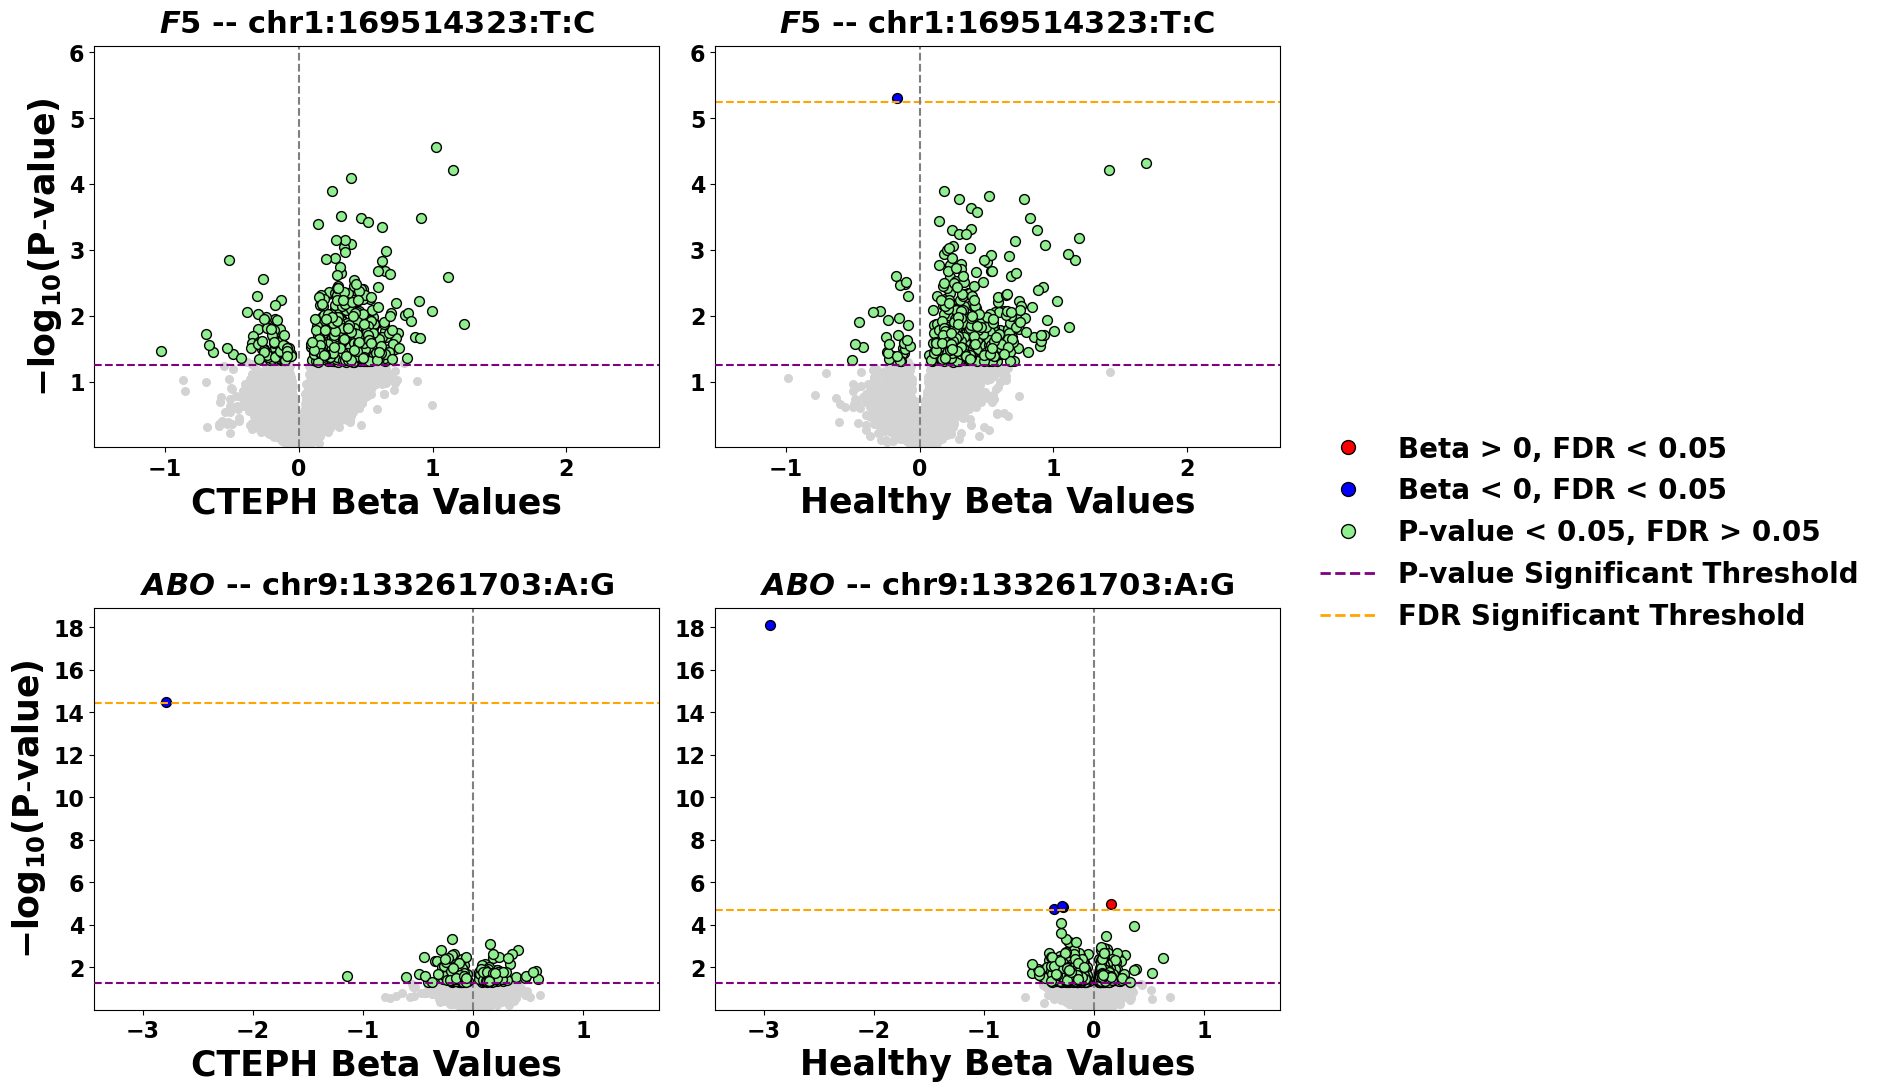

In [157]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.lines import Line2D

plt.style.use('default')  # Set the style of the plot
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.weight'] = 'bold'

keys = ['chr1:169514323:T:C', 'chr9:133261703:A:G']
fig, axes = plt.subplots(len(keys), 2, figsize=(13, 6 * len(keys)))

for i, key in enumerate(keys):

    case_beta = results_dict[key]['case_beta']
    case_pvalue = results_dict[key]['case_pvalue']
    case_fdr = results_dict[key]['case_fdr']
    control_beta = results_dict[key]['control_beta']
    control_pvalue = results_dict[key]['control_pvalue']
    control_fdr = results_dict[key]['control_fdr']

    case_beta_series = pd.Series(case_beta)
    case_pvalue_series = pd.Series(case_pvalue)
    case_fdr_series = pd.Series(case_fdr)
    control_beta_series = pd.Series(control_beta)
    control_pvalue_series = pd.Series(control_pvalue)
    control_fdr_series = pd.Series(control_fdr)

    ax1 = axes[i, 0]
    case_significant = case_fdr_series < 0.05
    case_pvalue_significant = (case_pvalue_series < 0.05) & (case_fdr_series > 0.05)
    if any(case_fdr_series < 0.05):  # Check if there are any FDR < 0.05 values
        case_max_pvalue_fdr = max(case_pvalue_series[case_fdr_series < 0.05])
        case_fdr_log_threshold = -np.log10(case_max_pvalue_fdr)
        ax1.axhline(y=case_fdr_log_threshold-0.05, color='orange', linestyle='--', linewidth=1.5, label='FDR < 0.05')
        
    ax1.axhline(y=-np.log10(0.05)-0.05, color='purple', linestyle='--', linewidth=1.5, zorder=11)
    ax1.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)

    ax1.scatter(case_beta_series[case_significant & (case_beta_series > 0)], -np.log10(case_pvalue_series[case_significant & (case_beta_series > 0)]),
                c='red', label='beta > 0', alpha=1, s=50, edgecolor='black')
    ax1.scatter(case_beta_series[case_significant & (case_beta_series < 0)], -np.log10(case_pvalue_series[case_significant & (case_beta_series < 0)]),
                c='blue', label='beta < 0', alpha=1, s=50, edgecolor='black')
    ax1.scatter(case_beta_series[case_pvalue_significant], -np.log10(case_pvalue_series[case_pvalue_significant]),
                c='lightgreen', alpha=1, s=50, zorder=10, edgecolor='black')
    ax1.scatter(case_beta_series[~case_significant & ~case_pvalue_significant], -np.log10(case_pvalue_series[~case_significant & ~case_pvalue_significant]),
                c='lightgray', alpha=1, s=30, zorder=0)
    ax1.set_xlabel('CTEPH Beta Values', fontsize=25, weight='bold')
    ax1.set_ylabel(r'$\mathbf{-log_{10}(P\text{-}value)}$', fontsize=25, weight='bold')

    ax2 = axes[i, 1]
    control_significant = control_fdr_series < 0.05
    control_pvalue_significant = (control_pvalue_series < 0.05) & (control_fdr_series > 0.05)
    if any(control_fdr_series < 0.05):  # Check if there are any FDR < 0.05 values
        control_max_pvalue_fdr = max(control_pvalue_series[control_fdr_series < 0.05])
        control_fdr_log_threshold = -np.log10(control_max_pvalue_fdr)
        ax2.axhline(y=control_fdr_log_threshold-0.05, color='orange', linestyle='--', linewidth=1.5, label='FDR < 0.05')
        
    ax2.axhline(y=-np.log10(0.05)-0.05, color='purple', linestyle='--', linewidth=1.5, zorder=11)
    ax2.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)

    ax2.scatter(control_beta_series[control_significant & (control_beta_series > 0)], -np.log10(control_pvalue_series[control_significant & (control_beta_series > 0)]),
                c='red', label='beta > 0', alpha=1, s=50, edgecolor='black')
    ax2.scatter(control_beta_series[control_significant & (control_beta_series < 0)], -np.log10(control_pvalue_series[control_significant & (control_beta_series < 0)]),
                c='blue', label='beta < 0', alpha=1, s=50, edgecolor='black')
    ax2.scatter(control_beta_series[control_pvalue_significant], -np.log10(control_pvalue_series[control_pvalue_significant]),
                c='lightgreen', alpha=1, s=50, zorder=10, edgecolor='black')
    ax2.scatter(control_beta_series[~control_significant & ~control_pvalue_significant], -np.log10(control_pvalue_series[~control_significant & ~control_pvalue_significant]),
                c='lightgray', alpha=1, s=30, zorder=0)
    ax2.set_xlabel('Healthy Beta Values', fontsize=25, weight='bold')
    # ax2.set_ylabel('-log$_{10}$(P-value)', fontsize=18, weight='bold')
    
    # Calculate min and max for current key
    min_beta = min(min(case_beta_series), min(control_beta_series)) - 0.5
    max_beta = max(max(case_beta_series), max(control_beta_series)) + 1
    min_pvalue = min(min(case_pvalue_series), min(control_pvalue_series))
    max_pvalue = max(max(case_pvalue_series), max(control_pvalue_series))

    ax1.set_xlim([min_beta, max_beta])
    ax2.set_xlim([min_beta, max_beta])
    ax1.set_ylim([-np.log10(max_pvalue), -np.log10(min_pvalue) + 0.8])
    ax2.set_ylim([-np.log10(max_pvalue), -np.log10(min_pvalue) + 0.8])

    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.yaxis.set_major_locator(MaxNLocator(integer=True))

    ax1.tick_params(axis='both', labelsize=16)
    ax2.tick_params(axis='both', labelsize=16)
    
    gene = known_loci.loc[known_loci['ID'] == key, 'GENE'].values[0]
    ax1.set_title(r'$\mathit{\boldsymbol{' + gene + '}}$' + f' -- {key}', fontsize=22, y=1.09, verticalalignment='top', transform=ax1.transAxes, weight='bold')
    ax2.set_title(r'$\mathit{\boldsymbol{' + gene + '}}$' + f' -- {key}', fontsize=22, y=1.09, verticalalignment='top', transform=ax2.transAxes, weight='bold')

fig.legend(handles=[plt.Line2D([0], [0], color='red', marker='o', linestyle='', markersize=10, markeredgecolor='black', label='Beta > 0, FDR < 0.05'),
                    plt.Line2D([0], [0], color='blue', marker='o', linestyle='', markersize=10, markeredgecolor='black', label='Beta < 0, FDR < 0.05'),
                    plt.Line2D([0], [0], color='lightgreen', marker='o', linestyle='', markersize=10, markeredgecolor='black', label='P-value < 0.05, FDR > 0.05'),
                    plt.Line2D([0], [0], color='purple', linestyle='--', linewidth=2, label='P-value Significant Threshold'),
                    plt.Line2D([0], [0], color='orange', linestyle='--', linewidth=2, label='FDR Significant Threshold')],
                    # plt.Line2D([0], [0], color='gray', linestyle='--', linewidth=2, label='Beta Value = 0')],
          loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False, fontsize=20, markerscale=1)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
plt.subplots_adjust(hspace=0.4)  
plt.show()


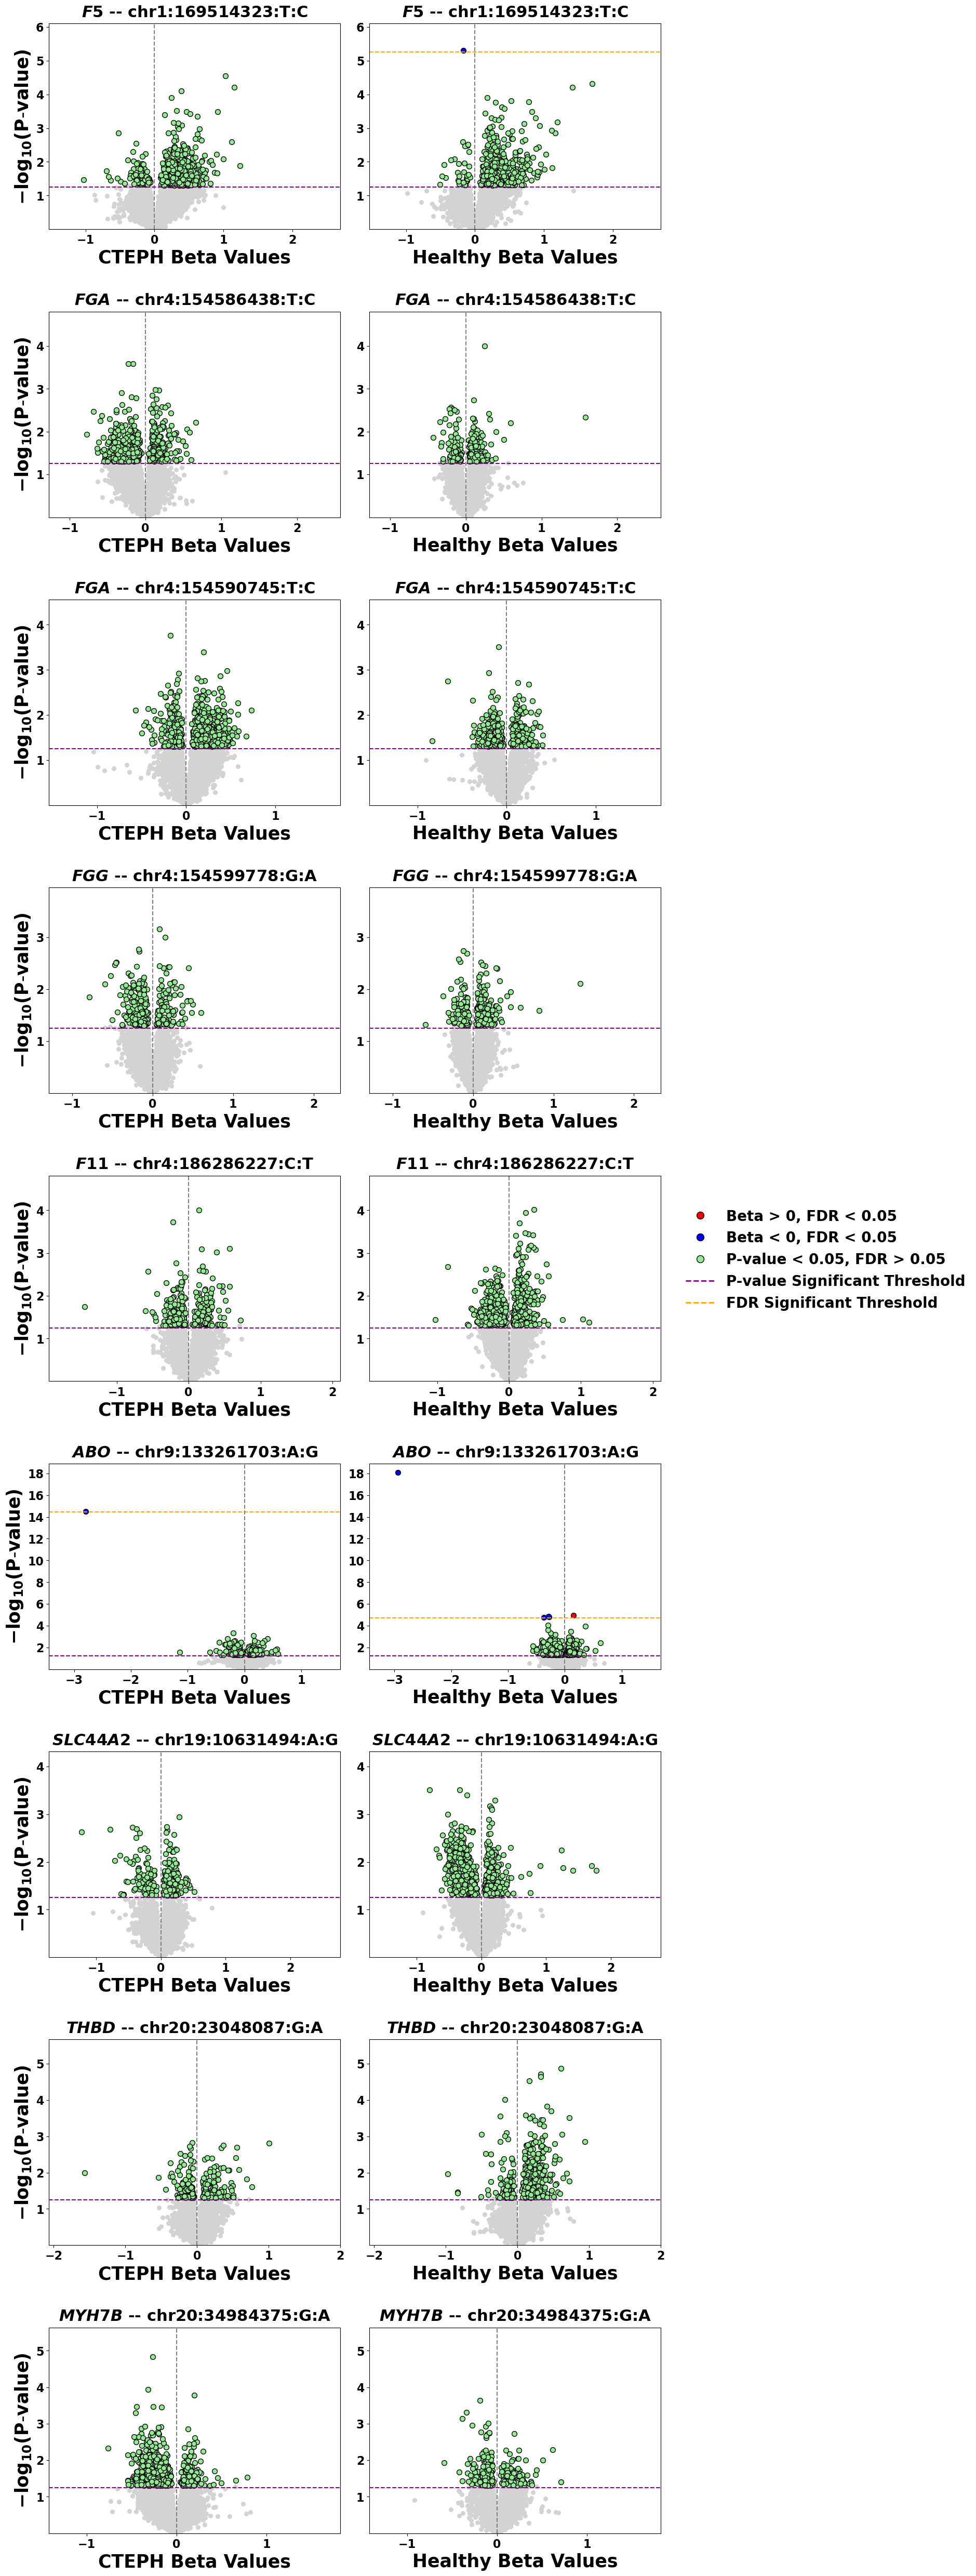

In [160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.lines import Line2D

plt.style.use('default')  # Set the style of the plot
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.weight'] = 'bold'

keys = list(results_dict.keys())
fig, axes = plt.subplots(len(keys), 2, figsize=(13, 6 * len(keys)))

for i, key in enumerate(keys):

    case_beta = results_dict[key]['case_beta']
    case_pvalue = results_dict[key]['case_pvalue']
    case_fdr = results_dict[key]['case_fdr']
    control_beta = results_dict[key]['control_beta']
    control_pvalue = results_dict[key]['control_pvalue']
    control_fdr = results_dict[key]['control_fdr']

    case_beta_series = pd.Series(case_beta)
    case_pvalue_series = pd.Series(case_pvalue)
    case_fdr_series = pd.Series(case_fdr)
    control_beta_series = pd.Series(control_beta)
    control_pvalue_series = pd.Series(control_pvalue)
    control_fdr_series = pd.Series(control_fdr)

    ax1 = axes[i, 0]
    case_significant = case_fdr_series < 0.05
    case_pvalue_significant = (case_pvalue_series < 0.05) & (case_fdr_series > 0.05)
    if any(case_fdr_series < 0.05):  # Check if there are any FDR < 0.05 values
        case_max_pvalue_fdr = max(case_pvalue_series[case_fdr_series < 0.05])
        case_fdr_log_threshold = -np.log10(case_max_pvalue_fdr)
        ax1.axhline(y=case_fdr_log_threshold-0.05, color='orange', linestyle='--', linewidth=1.5, label='FDR < 0.05')
        
    ax1.axhline(y=-np.log10(0.05)-0.05, color='purple', linestyle='--', linewidth=1.5, zorder=11)
    ax1.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)

    ax1.scatter(case_beta_series[case_significant & (case_beta_series > 0)], -np.log10(case_pvalue_series[case_significant & (case_beta_series > 0)]),
                c='red', label='beta > 0', alpha=1, s=50, edgecolor='black')
    ax1.scatter(case_beta_series[case_significant & (case_beta_series < 0)], -np.log10(case_pvalue_series[case_significant & (case_beta_series < 0)]),
                c='blue', label='beta < 0', alpha=1, s=50, edgecolor='black')
    ax1.scatter(case_beta_series[case_pvalue_significant], -np.log10(case_pvalue_series[case_pvalue_significant]),
                c='lightgreen', alpha=1, s=50, zorder=10, edgecolor='black')
    ax1.scatter(case_beta_series[~case_significant & ~case_pvalue_significant], -np.log10(case_pvalue_series[~case_significant & ~case_pvalue_significant]),
                c='lightgray', alpha=1, s=30, zorder=0)
    ax1.set_xlabel('CTEPH Beta Values', fontsize=25, weight='bold')
    ax1.set_ylabel(r'$\mathbf{-log_{10}(P\text{-}value)}$', fontsize=25, weight='bold')

    ax2 = axes[i, 1]
    control_significant = control_fdr_series < 0.05
    control_pvalue_significant = (control_pvalue_series < 0.05) & (control_fdr_series > 0.05)
    if any(control_fdr_series < 0.05):  # Check if there are any FDR < 0.05 values
        control_max_pvalue_fdr = max(control_pvalue_series[control_fdr_series < 0.05])
        control_fdr_log_threshold = -np.log10(control_max_pvalue_fdr)
        ax2.axhline(y=control_fdr_log_threshold-0.05, color='orange', linestyle='--', linewidth=1.5, label='FDR < 0.05')
        
    ax2.axhline(y=-np.log10(0.05)-0.05, color='purple', linestyle='--', linewidth=1.5, zorder=11)
    ax2.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)

    ax2.scatter(control_beta_series[control_significant & (control_beta_series > 0)], -np.log10(control_pvalue_series[control_significant & (control_beta_series > 0)]),
                c='red', label='beta > 0', alpha=1, s=50, edgecolor='black')
    ax2.scatter(control_beta_series[control_significant & (control_beta_series < 0)], -np.log10(control_pvalue_series[control_significant & (control_beta_series < 0)]),
                c='blue', label='beta < 0', alpha=1, s=50, edgecolor='black')
    ax2.scatter(control_beta_series[control_pvalue_significant], -np.log10(control_pvalue_series[control_pvalue_significant]),
                c='lightgreen', alpha=1, s=50, zorder=10, edgecolor='black')
    ax2.scatter(control_beta_series[~control_significant & ~control_pvalue_significant], -np.log10(control_pvalue_series[~control_significant & ~control_pvalue_significant]),
                c='lightgray', alpha=1, s=30, zorder=0)
    ax2.set_xlabel('Healthy Beta Values', fontsize=25, weight='bold')
    # ax2.set_ylabel('-log$_{10}$(P-value)', fontsize=18, weight='bold')
    
    # Calculate min and max for current key
    min_beta = min(min(case_beta_series), min(control_beta_series)) - 0.5
    max_beta = max(max(case_beta_series), max(control_beta_series)) + 1
    min_pvalue = min(min(case_pvalue_series), min(control_pvalue_series))
    max_pvalue = max(max(case_pvalue_series), max(control_pvalue_series))

    ax1.set_xlim([min_beta, max_beta])
    ax2.set_xlim([min_beta, max_beta])
    ax1.set_ylim([-np.log10(max_pvalue), -np.log10(min_pvalue) + 0.8])
    ax2.set_ylim([-np.log10(max_pvalue), -np.log10(min_pvalue) + 0.8])

    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.yaxis.set_major_locator(MaxNLocator(integer=True))

    ax1.tick_params(axis='both', labelsize=16)
    ax2.tick_params(axis='both', labelsize=16)
    
    gene = known_loci.loc[known_loci['ID'] == key, 'GENE'].values[0]
    ax1.set_title(r'$\mathit{\boldsymbol{' + gene + '}}$' + f' -- {key}', fontsize=22, y=1.09, verticalalignment='top', transform=ax1.transAxes, weight='bold')
    ax2.set_title(r'$\mathit{\boldsymbol{' + gene + '}}$' + f' -- {key}', fontsize=22, y=1.09, verticalalignment='top', transform=ax2.transAxes, weight='bold')

fig.legend(handles=[plt.Line2D([0], [0], color='red', marker='o', linestyle='', markersize=10, markeredgecolor='black', label='Beta > 0, FDR < 0.05'),
                    plt.Line2D([0], [0], color='blue', marker='o', linestyle='', markersize=10, markeredgecolor='black', label='Beta < 0, FDR < 0.05'),
                    plt.Line2D([0], [0], color='lightgreen', marker='o', linestyle='', markersize=10, markeredgecolor='black', label='P-value < 0.05, FDR > 0.05'),
                    plt.Line2D([0], [0], color='purple', linestyle='--', linewidth=2, label='P-value Significant Threshold'),
                    plt.Line2D([0], [0], color='orange', linestyle='--', linewidth=2, label='FDR Significant Threshold')],
                    # plt.Line2D([0], [0], color='gray', linestyle='--', linewidth=2, label='Beta Value = 0')],
          loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False, fontsize=20, markerscale=1)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
plt.subplots_adjust(hspace=0.4)  
plt.show()